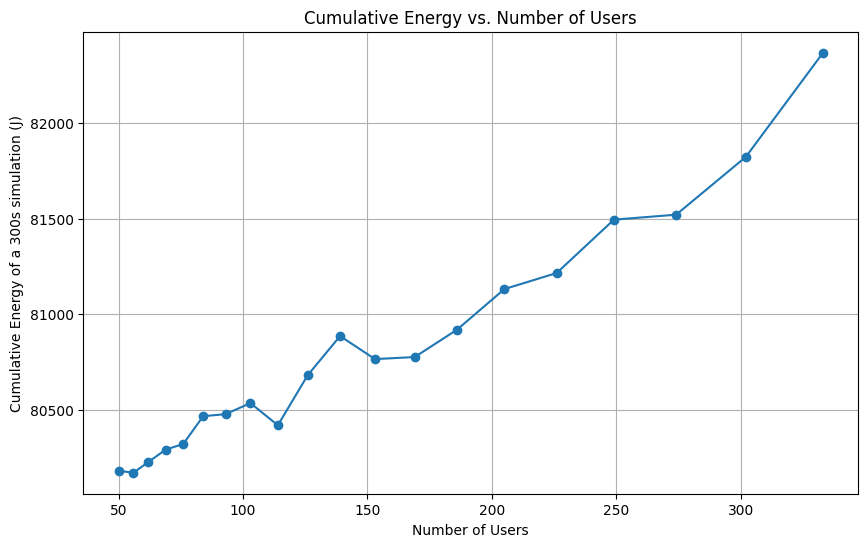

In [16]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# Dictionary to hold dataframes
dict_df = {}

# Read all energy history files
for file in glob.glob("../output/energy_history_*.csv"):
    df = pd.read_csv(file)
    dict_df[file] = df

# Prepare lists to store results
user_counts = []
cumulative_energies = []

# Process each file
for file, df in dict_df.items():
    # Calculate the cumulative energy (sum of all nodes)
    cumulative_energy = df.sum().sum()
    cumulative_energies.append(cumulative_energy)

    # Extract user count from file name (assuming format includes user count)
    # Example filename: energy_history_user10.csv
    user_count = int(file.split("_")[-1].replace(".csv", "").replace("user", ""))
    user_counts.append(user_count)

# Combine and sort the data by user count
data = list(zip(user_counts, cumulative_energies))
data.sort(key=lambda x: x[0])  # Sort by user count

# Unzip the sorted data
sorted_user_counts, sorted_cumulative_energies = zip(*data)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sorted_user_counts, sorted_cumulative_energies, marker='o', linestyle='-')
plt.title("Cumulative Energy vs. Number of Users")
plt.xlabel("Number of Users")
plt.ylabel("Cumulative Energy of a 300s simulation (J)")
plt.grid()
plt.show()
